In [1]:
%load_ext autoreload
%autoreload 2

import json
import random
import string
import re
from pathlib import Path
from collections import Counter

import torch
import nnsight
from transformers import AutoTokenizer

# --- Parameters ---
# Match the plan's requirements
DATASET_SIZE = 32
LEXICON_CONDITION = "mixed" 
SEED = 23
MODEL_NAME = "meta-llama/Llama-3.3-70B-Instruct"
OUTPUT_FILE = Path("../data/patching_dataset_N32_mixed.jsonl")

# For reproducibility
random.seed(SEED)
torch.manual_seed(SEED)

# Make sure the output directory exists
OUTPUT_FILE.parent.mkdir(parents=True, exist_ok=True)

In [2]:
from transformers import AutoTokenizer
import nnsight
import torch

# --- Load Model and Tokenizer (Revised) ---

# 1. Load the "fast" tokenizer explicitly.
# This is crucial because the fast version has the .char_to_token() method we need.
# trust_remote_code=True is often needed for newer models like Llama 3.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True)

# Llama-3 tokenizers don't have a pad_token by default. We'll set it to the eos_token.
# This is good practice and prevents potential issues later.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 2. Load the model via nnsight, passing our pre-loaded tokenizer.
# This ensures nnsight uses the exact tokenizer object we need.
model = nnsight.LanguageModel(
    MODEL_NAME,
    tokenizer=tokenizer,  # Pass the tokenizer here
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

print("Model and fast tokenizer loaded successfully.")

Model and fast tokenizer loaded successfully.


In [3]:
import string

# --- Data generation code (adapted from analogies5/src/dataset/build_dataset.py) ---

# Relation families and lexicons
R1_NAME = "made of"
R1_SYNS = ["made of", "crafted out of", "composed of", "constructed from"]
R2_FAMILIES = {
    "located in": ["located in", "situated in", "housed in", "inside", "within"],
    "rests on"  : ["resting on", "placed on", "sitting on", "perched on", "set on"],
}
REAL_SUBJECTS = ["jewelry", "vase", "sculpture", "statue", "artifact", "bottle", "cup", "kiosk", "bench", "jar"]
REAL_MATERIALS = ["resin", "plastic", "bronze", "oak", "clay", "marble", "glass", "steel"]
REAL_PLACES    = ["hotel", "museum", "library", "gallery", "mall", "park", "school", "office"]
REAL_SURFACES  = ["desk", "shelf", "table", "counter", "stand", "pedestal", "workbench"]
TEMPLATES = [
    #("S1:O1::S2:?", "o2", "Task-2 (S→O)"),
    #("O1:S1::O2:?", "s2", "Task-1 (O→S)"),
    #("S2:O2::S1:?", "o1", "Task-3 (O→O across)"),
    #("O2:S2::O1:?", "s1", "Task-4 (S→S across)"),
    ("S1:S2::O1:?", "o2", "Task-5 (O→O across)")
]

# Helper functions (copied directly)
COMMON_DIGRAPHS = ["th","br","tr","cl","st","gl","pl","pr","cr","gr","dr","fl","fr","sl","sp","sk"]
VOWELS = "aeiou"
CONSONANTS = ''.join(sorted(set(string.ascii_lowercase) - set(VOWELS)))

def random_fake_word(min_len=5, max_len=9) -> str:
    target = random.randint(min_len, max_len)
    out = []
    use_vowel = random.random() >= 0.65
    i = 0
    while i < target:
        if not use_vowel and i <= target - 2 and random.random() < 0.33:
            dg = random.choice(COMMON_DIGRAPHS)
            out.append(dg)
            i += 2
        else:
            out.append(random.choice(VOWELS if use_vowel else CONSONANTS))
            i += 1
        use_vowel = not use_vowel
    word = "".join(out)[:target]
    if all(ch in VOWELS for ch in word) or all(ch in CONSONANTS for ch in word):
        word = list(word)
        mid = len(word) // 2
        word[mid] = random.choice(CONSONANTS if word[mid] in VOWELS else VOWELS)
        word = "".join(word)
    return word.lower()

def distinct_two(syns):
    if len(syns) == 1: return syns[0], syns[0]
    return random.sample(syns, 2)

def make_sentence(subject: str, rel_surface: str, obj: str, family_hint: str) -> str:
    s_phrase = f"The {subject}"
    if family_hint in ("made of", "filled with"):
        return f"{s_phrase} is {rel_surface} {obj}."
    else:
        return f"{s_phrase} is {rel_surface} the {obj}."

def pick_real_subject() -> str: return random.choice(REAL_SUBJECTS)
def pick_real_material() -> str: return random.choice(REAL_MATERIALS)
def pick_real_place() -> str: return random.choice(REAL_PLACES)
def pick_real_surface() -> str: return random.choice(REAL_SURFACES)

def build_nouns_for_condition(cond: str):
    r2_family = random.choice(list(R2_FAMILIES.keys()))
    if cond == "real":
        s1, s2 = distinct_two(REAL_SUBJECTS)
        o1, o2 = distinct_two(REAL_MATERIALS)
        if r2_family == "located in": o3, o4 = distinct_two(REAL_PLACES)
        else: o3, o4 = distinct_two(REAL_SURFACES)
        return (s1, o1, o3, "real"), (s2, o2, o4, "real"), r2_family
    if cond == "fake":
        s1, s2 = random_fake_word(), random_fake_word()
        o1, o2 = random_fake_word(), random_fake_word()
        o3, o4 = random_fake_word(), random_fake_word()
        return (s1, o1, o3, "fake"), (s2, o2, o4, "fake"), r2_family
    
    # mixed
    real_first = random.random() < 0.5
    if real_first:
        s1 = pick_real_subject(); o1 = pick_real_material()
        o3 = pick_real_place() if r2_family == "located in" else pick_real_surface()
        s2 = random_fake_word(); o2 = random_fake_word(); o4 = random_fake_word()
        return (s1, o1, o3, "real"), (s2, o2, o4, "fake"), r2_family
    else:
        s1 = random_fake_word(); o1 = random_fake_word(); o3 = random_fake_word()
        s2 = pick_real_subject(); o2 = pick_real_material()
        o4 = pick_real_place() if r2_family == "located in" else pick_real_surface()
        return (s1, o1, o3, "fake"), (s2, o2, o4, "real"), r2_family

def build_one_example(lexicon_condition: str, template_slot: int) -> dict:
    (s1, o1, o3, s1_type), (s2, o2, o4, s2_type), r2_family = build_nouns_for_condition(lexicon_condition)
    r1_s1, r1_s2 = distinct_two(R1_SYNS)
    r2_syns = R2_FAMILIES[r2_family]
    r2_s1, r2_s2 = random.choice(r2_syns), random.choice(r2_syns)

    # *** MODIFICATION: Store original sentences before shuffling ***
    facts = {
        "r1_s1": make_sentence(s1, r1_s1, o1, family_hint="made of"),
        "r2_s1": make_sentence(s1, r2_s1, o3, family_hint=r2_family),
        "r1_s2": make_sentence(s2, r1_s2, o2, family_hint="made of"),
        "r2_s2": make_sentence(s2, r2_s2, o4, family_hint=r2_family),
    }
    sents = list(facts.values())
    random.shuffle(sents)
    story = " ".join(sents)

    template, answer_key, task_name = TEMPLATES[0]
    
    # Create the analogy prompt and identify the correct answer word
    analogy_map = {"s1": s1, "o1": o1, "s2": s2, "o2": o2}
    if template == "S1:O1::S2:?": analogy = f"{s1} is to {o1} as {s2} is to"
    elif template == "O1:S1::O2:?": analogy = f"{o1} is to {s1} as {o2} is to"
    elif template == "S2:O2::S1:?": analogy = f"{s2} is to {o2} as {s1} is to"
    elif template == "S1:S2::O1:?": analogy = f"{s1} is to {s2} as {o1} is to"
    else: analogy = f"{o2} is to {s2} as {o1} is to"
    answer = analogy_map[answer_key]
    
    # Also return nouns for easy access
    nouns = {"s1":s1, "o1":o1, "s2":s2, "o2":o2, "o3":o3, "o4":o4}

    meta = {
        "relation_target": R1_NAME, "relation_distractor_family": r2_family,
        "surface_r1_s1": r1_s1, "surface_r1_s2": r1_s2,
        "surface_r2_s1": r2_s1, "surface_r2_s2": r2_s2,
        "lexicon_condition": lexicon_condition, "s1_noun_type": s1_type, "s2_noun_type": s2_type,
        "seed": SEED, "template": template, "task": task_name,
    }
    
    return {
        "story": story, "analogy": analogy, "answer": answer, "meta": meta,
        # *** NEW: Return nouns and facts for token indexing ***
        "nouns": nouns, "facts": facts,
    }

print("Data generation helpers defined.")

Data generation helpers defined.


In [4]:
# --- Token Indexing Logic (Revised) ---

INSTRUCTION = "Finish the analogy in one word.\n"

def build_prompts_and_find_indices(ex, tokenizer):
    """
    Builds the source (R1) and base (R2) prompts and robustly finds token indices
    for all key nouns using character-to-token mapping on the encoding object.
    """
    # 1. Build the SOURCE prompt (correct R1 analogy)
    prompt_source = f"{INSTRUCTION}{ex['story']}\n\n{ex['analogy']}"
    
    # Pre-tokenize the source prompt to get an encoding object.
    # We will call char_to_token on this object, which is the correct, robust way.
    encoding_source = tokenizer(prompt_source)

    # 2. Build the BASE prompt (the "corrupted" one, targeting R2)
    nouns = ex['nouns']
    s1, o1, s2, o2 = nouns['s1'], nouns['o1'], nouns['s2'], nouns['o2']
    o3, o4 = nouns['o3'], nouns['o4']
    template_str = ex['meta']['template']

    # Create the analogy cue for the R2 relation
    if template_str == "S1:O1::S2:?":   base_analogy = f"{s1} is to {o3} as {s2} is to"
    elif template_str == "O1:S1::O2:?": base_analogy = f"{o3} is to {s1} as {o4} is to"
    elif template_str == "S2:O2::S1:?": base_analogy = f"{s2} is to {o4} as {s1} is to"
    elif template_str == "S1:S2::O1:?": base_analogy = f"{s1} is to {s2} as {o3} is to"
    else: # "O2:S2::O1:?"
        base_analogy = f"{o4} is to {s2} as {o3} is to"
    prompt_base = f"{INSTRUCTION}{ex['story']}\n\n{base_analogy}"

    # 3. Find token indices in the SOURCE prompt
    indices = {}
    
    # Helper to find the last token of a word in a specific context string (sentence or cue)
    def find_indices_in_context(context_str, prompt_str, encoding_obj, nouns_to_find):
        context_start_char = prompt_str.find(context_str)
        if context_start_char == -1: return {n: -1 for n in nouns_to_find}

        results = {}
        for noun_key, noun_val in nouns_to_find.items():
            try:
                word_start_in_context = context_str.index(noun_val)
                abs_char_start = context_start_char + word_start_in_context
                end_char = abs_char_start + len(noun_val) - 1
                # Call char_to_token on the encoding object, not the tokenizer
                token_idx = encoding_obj.char_to_token(end_char)
                results[noun_key] = token_idx if token_idx is not None else -1
            except ValueError:
                results[noun_key] = -1 # Word not in context
        return results

    # Find nouns in their respective fact sentences
    indices.update(find_indices_in_context(ex['facts']['r1_s1'], prompt_source, encoding_source, {'s1_in_r1': s1, 'o1_in_r1': o1}))
    indices.update(find_indices_in_context(ex['facts']['r2_s1'], prompt_source, encoding_source, {'s1_in_r2': s1, 'o3_in_r2': o3}))
    indices.update(find_indices_in_context(ex['facts']['r1_s2'], prompt_source, encoding_source, {'s2_in_r1': s2, 'o2_in_r1': o2}))
    indices.update(find_indices_in_context(ex['facts']['r2_s2'], prompt_source, encoding_source, {'s2_in_r2': s2, 'o4_in_r2': o4}))

    # Find nouns in the final R1 analogy cue
    indices.update(find_indices_in_context(ex['analogy'], prompt_source, encoding_source, {'s1_in_cue': s1, 'o1_in_cue': o1, 's2_in_cue': s2, 'o2_in_cue': o2}))
    
    # The analogy site is the final token of the prompt
    indices['analogy_site'] = len(encoding_source.tokens()) - 1

    # Check that nouns were found in the facts (they are guaranteed to be there)
    required_keys = ['s1_in_r1', 'o1_in_r1', 's1_in_r2', 'o3_in_r2', 's2_in_r1', 'o2_in_r1', 's2_in_r2', 'o4_in_r2']
    if any(indices.get(k, -1) == -1 for k in required_keys):
        print(f"WARNING: A required token was not found in a fact sentence for item with nouns: {ex['nouns']}. Skipping.")
        return None, None, None

    return prompt_source, prompt_base, indices

print("Token indexing function defined.")

Token indexing function defined.


In [16]:
import time

# --- Generate the dataset and save with indices ---

items = []
# Cycle through templates for a perfect 25% balance
t_slot = 0
for i in range(DATASET_SIZE):
    ex = build_one_example(LEXICON_CONDITION, template_slot=t_slot)
    
    # Use the new, more robust indexing function
    prompt_source, prompt_base, indices = build_prompts_and_find_indices(ex, tokenizer)

    if prompt_source is None: # Skip if indexing failed for any reason
        continue
    
    # Add the new artifacts to the example dict
    ex['prompt_source'] = prompt_source
    ex['prompt_base'] = prompt_base
    ex['token_indices'] = indices
    
    # We don't need these intermediate structures in the final file
    del ex['nouns']
    del ex['facts']
    
    items.append(ex)
    #t_slot = (t_slot + 1) % 4

# Write to JSONL
with OUTPUT_FILE.open("w", encoding="utf-8") as f:
    for ex in items:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

print(f"Wrote {len(items)} examples to {OUTPUT_FILE}")

# --- Verification ---
if items:
    print("\n--- Verifying first example ---")
    first_item = items[0]
    toks = tokenizer.encode(first_item['prompt_source'])
    tok_str = [tokenizer.decode([t]) for t in toks]

    print(f"Source Prompt: \"{first_item['prompt_source']}\"")
    print(f"Base Prompt:   \"{first_item['prompt_base']}\"")
    print(f"Gold Answer: {first_item['answer']}")
    print("\n--- Token Indices Verification ---")
    for name, idx in sorted(first_item['token_indices'].items()):
        # A value of -1 is now expected for nouns not present in the analogy cue
        if idx != -1 and idx < len(tok_str):
            print(f"{name:<15}: index={idx:<4} token='{tok_str[idx]}'")
        else:
            print(f"{name:<15}: NOT FOUND (index={idx})")
else:
    print("\n--- No items generated. Please check for warnings above. ---")

Wrote 32 examples to ../data/patching_dataset_N32_mixed.jsonl

--- Verifying first example ---
Source Prompt: "Finish the analogy in one word.
The feclur is made of placlugav. The artifact is crafted out of resin. The feclur is within the frifeslo. The artifact is within the library.

artifact is to feclur as resin is to"
Base Prompt:   "Finish the analogy in one word.
The feclur is made of placlugav. The artifact is crafted out of resin. The feclur is within the frifeslo. The artifact is within the library.

artifact is to feclur as library is to"
Gold Answer: placlugav

--- Token Indices Verification ---
analogy_site   : index=55   token=' to'
o1_in_cue      : index=53   token=' resin'
o1_in_r1       : index=26   token=' resin'
o2_in_cue      : NOT FOUND (index=-1)
o2_in_r1       : index=18   token='av'
o3_in_r2       : index=44   token=' library'
o4_in_r2       : index=37   token='lo'
s1_in_cue      : index=46   token='artifact'
s1_in_r1       : index=21   token=' artifact'
s1_in_r2

In [5]:
import os
os.chdir('/disk/u/gio/mechinterp/analogies5/')

In [7]:
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Literal, Optional, List
from src.intervention.analysis import collect_activations_efficient, collect_logits, activation_patch

# --- Step 2: Residual Stream Patching (Adapted from your analysis.py) ---

# 1. Load the dataset we just created
def read_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

items = read_jsonl('data/patching_dataset_N32_mixed.jsonl')
print(f"Loaded {len(items)} items from {OUTPUT_FILE}")

Loaded 32 items from ../data/patching_dataset_N32_mixed.jsonl


In [ ]:
# --- Main Experiment Loop ---
all_results = []
# Use a smaller subset for a quicker test run if desired
dataset_subset = items[:1]

print("Starting residual stream patching experiment...")

for ex_idx, ex in enumerate(tqdm(dataset_subset)):
    answer_token_id = tokenizer.encode(f" {ex['answer']}", add_special_tokens=False)[0]

    # 1. Collect activations from the source prompt (correct analogy)
    source_activations = collect_activations_efficient(model, ex['prompt_source'])

    base_logits = collect_logits(
        model,
        ex['prompt_base']
    )

    source_target_logits_base = base_logits[-1][answer_token_id]

    # 3. Run patching from source to base
    df_patch = activation_patch(
        model,
        prompt=ex['prompt_base'],
        activations=source_activations,
        target_token_id=answer_token_id,
        source_target_logits_base=source_target_logits_base,
    )
    #df_patch["ex_idx"] = ex_idx
    all_results.append(df_patch)

print("Experiment complete.")

# Combine results and save
df_resid = pd.concat(all_results)
df_resid.to_csv("../data/residual_patching_results_32.csv", index=False)
print("Results saved to ../data/residual_patching_results_32.csv")

Loaded 128 items from ../data/patching_dataset_N32_mixed.jsonl
Starting residual stream patching experiment...


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
# If patched_activations is a list of lists containing tensors
# Convert BFloat16 to float32 before converting to numpy to avoid dtype issues
patched_activations = [
    [item.detach().cpu().float().numpy() if torch.is_tensor(item) else item for item in sublist]
    if isinstance(sublist, list) else 
    (sublist.detach().cpu().float().numpy() if torch.is_tensor(sublist) else sublist)
    for sublist in df_patch
]

In [ ]:
from src.visualization.patching import patching_heatmap

patching_heatmap(
    model,
    patched_activations,
    source_input_ids,
    base_input_ids,
    kind="residual"
)

Aggregating results for heatmap...


KeyError: 'layer'

In [8]:
import gc

def free_gpu_cache():
    gc.collect()
    torch.cuda.empty_cache()

free_gpu_cache()

In [9]:
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from src.intervention.analysis import collect_activations_efficient, collect_logits

# --- Step 2: Residual Stream Patching (Full Experiment) ---

# 1. Load the dataset we just created
def read_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

items = read_jsonl('data/patching_dataset_N32_mixed.jsonl')
print(f"Loaded {len(items)} items from {'data/patching_dataset_N32_mixed.jsonl'}")

POSITIONS_OF_INTEREST = [
    's1_in_r1', 'o1_in_r1', 's2_in_r1', 'o2_in_r1',
    's1_in_r2', 'o3_in_r2', 's2_in_r2', 'o4_in_r2',
    's1_in_cue', 's2_in_cue', 'o1_in_cue', 'o2_in_cue',
    'analogy_site'
]

Loaded 32 items from data/patching_dataset_N32_mixed.jsonl


In [ ]:
# --- Main Experiment Loop ---
all_results = []
dataset_subset = items

print("Starting residual stream patching experiment across all examples...")

for ex_idx, ex in enumerate(tqdm(dataset_subset, desc="Examples")):
    answer_token_id = tokenizer.encode(f" {ex['answer']}", add_special_tokens=False)[0]

    source_activations = collect_activations_efficient(model, ex['prompt_source'])
    base_logits = collect_logits(model, ex['prompt_base'])
    base_target_log_prob = torch.log_softmax(base_logits[-1], dim=-1)[answer_token_id].item()

    # Create a temporary wrapper to run the patching logic for this specific experiment
    def run_patching_for_example(ex_data):
        rows = []
        pbar_inner = tqdm(total=len(source_activations) * len(POSITIONS_OF_INTEREST), leave=False, desc="Patching Layers")
        for layer, source_act in enumerate(source_activations):
            for pos_key in POSITIONS_OF_INTEREST:
                pos_idx = ex_data['token_indices'].get(pos_key, -1)
                
                if pos_idx == -1:
                    pbar_inner.update(1)
                    continue

                with model.trace(ex_data['prompt_base'], validate=False) as tracer:
                    model.model.layers[layer].output[0][pos_idx, :] = source_act[pos_idx, :]
                    
                    # Measurement remains the same.
                    logits = model.output.logits[0, -1, :]
                    log_probs = torch.log_softmax(logits, dim=-1)
                    patched_log_prob = log_probs[answer_token_id].save()

                log_prob_delta = patched_log_prob.item() - base_target_log_prob
                #if log_prob_delta != 0.0: print(log_prob_delta)
                rows.append({
                    "ex_idx": ex_idx, "layer": layer, "position": pos_key,
                    "log_prob_delta": log_prob_delta,
                })
                pbar_inner.update(1)
        pbar_inner.close()
        return rows

    try:
        patch_results_rows = run_patching_for_example(ex)
        all_results.extend(patch_results_rows)
    except Exception as e:
        print(f"Error: {e}")
        continue

print("Experiment complete.")

# --- Process Results into a DataFrame ---
df_resid = pd.DataFrame(all_results)
df_resid.to_csv("../data/residual_patching_results_32.csv", index=False)
print("Detailed results saved to ../data/residual_patching_results_32.csv")

Loaded 32 items from data/patching_dataset_N32_mixed.jsonl
Starting residual stream patching experiment across all examples...


Examples:   0%|          | 0/32 [00:00<?, ?it/s]

Patching Layers:   0%|          | 0/1040 [00:00<?, ?it/s]

Patching Layers:   0%|          | 0/1040 [00:00<?, ?it/s]

Error: index 57 is out of bounds for dimension 0 with size 57


Patching Layers:   0%|          | 0/1040 [00:00<?, ?it/s]

Error: index 61 is out of bounds for dimension 0 with size 61


Patching Layers:   0%|          | 0/1040 [00:00<?, ?it/s]

Patching Layers:   0%|          | 0/1040 [00:00<?, ?it/s]

Patching Layers:   0%|          | 0/1040 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [36]:
df_resid = pd.DataFrame(all_results)

Aggregating results for heatmap...
Plotting data with shape (positions, layers): (12, 80)
Data range: min=-0.0521, max=7.0964


<Figure size 640x480 with 0 Axes>

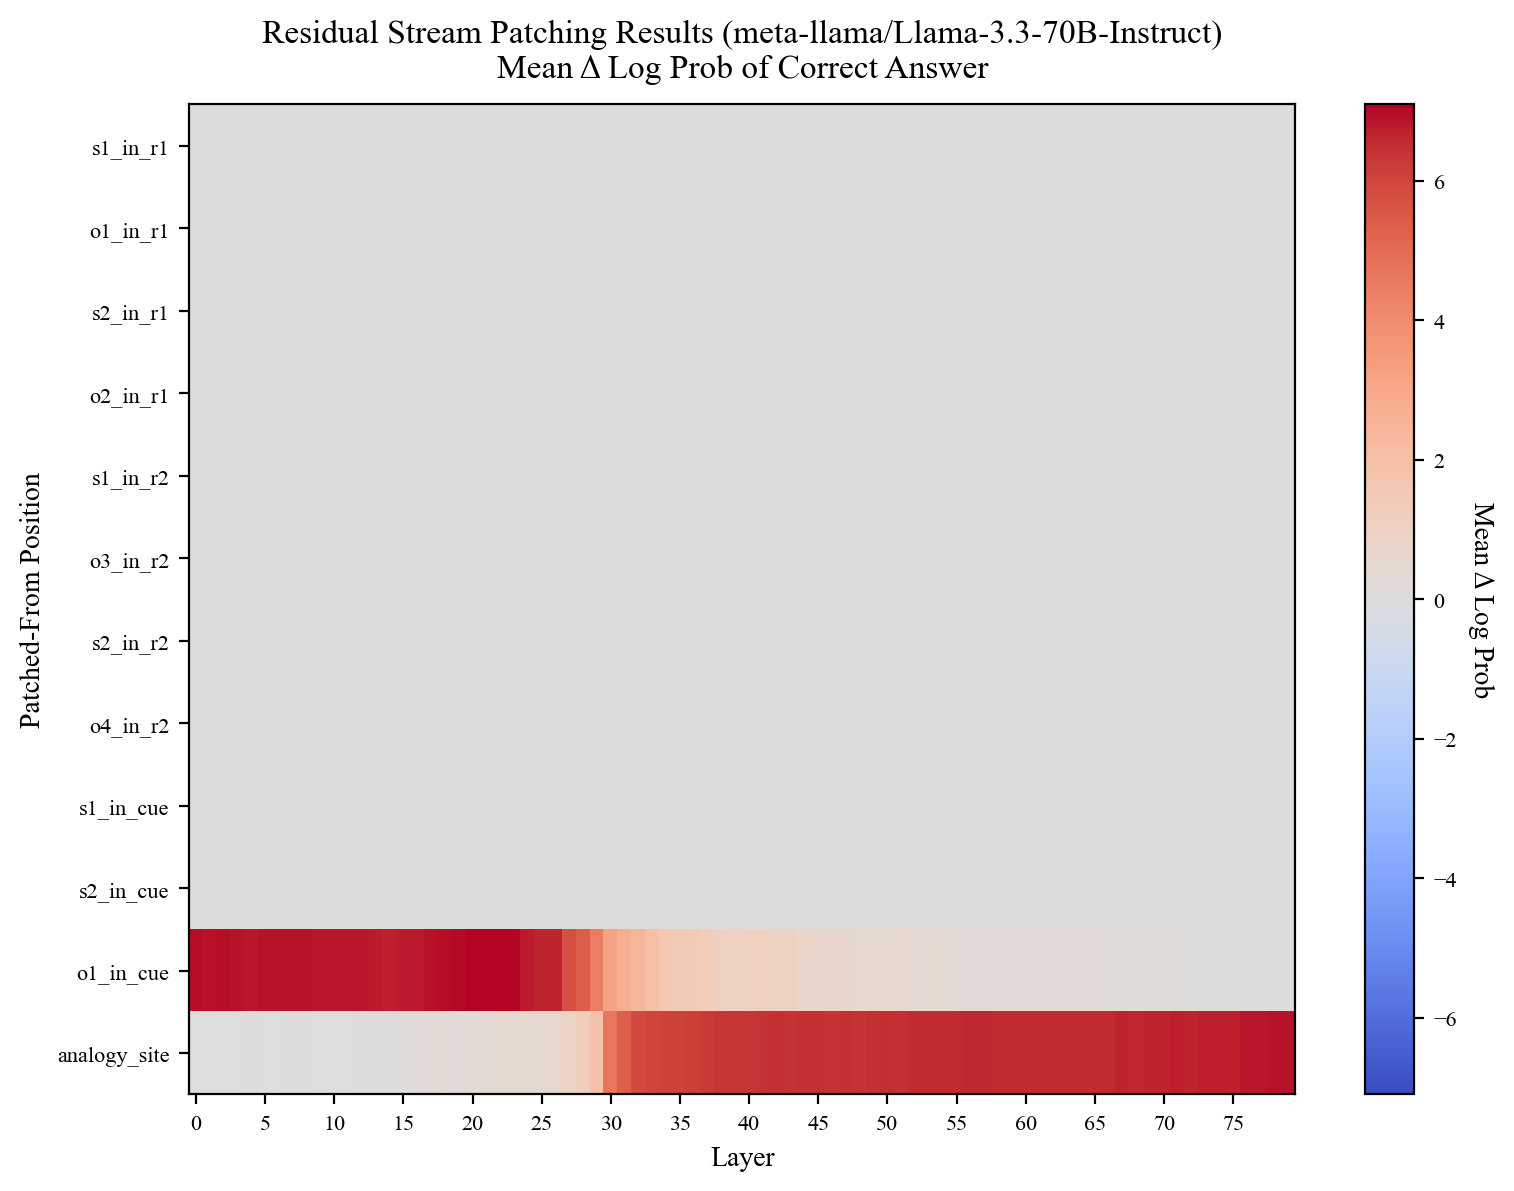


Heatmap saved to ../figures/residual_patch_heatmap.png

Layer with highest mean absolute impact: 32


,Mean Δ Log Prob
position,
analogy_site,5.885417
o1_in_cue,2.489583
o1_in_r1,0.000000
o2_in_r1,0.000000
o3_in_r2,0.000000
o4_in_r2,0.000000
s1_in_cue,0.000000
s1_in_r1,0.000000
s1_in_r2,0.000000


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Analysis and Visualization (Adapted from your patching.py) ---

print("Aggregating results for heatmap...")

# Average the change in log probability across all examples
mean_effects = df_resid.groupby(['layer', 'position'])['log_prob_delta'].mean().reset_index()

# Create a pivot table for the heatmap
heatmap_data = mean_effects.pivot(index='layer', columns='position', values='log_prob_delta')

# --- Your patching_heatmap function, minimally adapted for this experiment ---
def patching_heatmap_by_position(
    results_df: pd.DataFrame,
    title: str = "Residual Stream Patching Effects"
) -> None:
    """
    Visualize the patching heatmap from a DataFrame where rows are layers
    and columns are named positions.
    """
    # Transpose so positions are rows (y-axis) and layers are columns (x-axis)
    scores = results_df.T.to_numpy()
    position_labels = results_df.columns.tolist()
    
    print(f"Plotting data with shape (positions, layers): {scores.shape}")
    print(f"Data range: min={scores.min():.4f}, max={scores.max():.4f}")

    plt.rcdefaults()
    with plt.rc_context(
        rc={
            "font.family": "Times New Roman",
            "font.size": 8,
        }
    ):
        fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
        
        # Use a diverging colormap for deltas, centered at 0
        vmax = np.abs(scores).max() if np.abs(scores).max() > 0 else 1.0
        scale_kwargs = {"vmin": -vmax, "vmax": vmax, "cmap": "coolwarm"}

        heatmap = ax.pcolor(scores, **scale_kwargs)
        ax.invert_yaxis()
        
        # Y-axis: Use position names from the DataFrame columns
        ax.set_yticks([0.5 + i for i in range(len(position_labels))])
        ax.set_yticklabels(position_labels)
        
        # X-axis: layer labels
        num_layers = scores.shape[1]
        tick_indices = np.arange(0, num_layers, 5)
        ax.set_xticks(tick_indices + 0.5)
        ax.set_xticklabels(tick_indices)

        ax.set_title(title, fontsize=12, pad=10)
        ax.set_xlabel("Layer", fontsize=10)
        ax.set_ylabel("Patched-From Position", fontsize=10)

        color_scale = plt.colorbar(heatmap)
        color_scale.ax.set_ylabel("Mean Δ Log Prob", rotation=-90, va="bottom", fontsize=10)

        plt.tight_layout()
        plt.show()

# --- Plotting the Results ---
# Ensure the columns (positions) are in a consistent, logical order
ordered_positions = [p for p in POSITIONS_OF_INTEREST if p in heatmap_data.columns]
heatmap_data_ordered = heatmap_data[ordered_positions]

plot_title = f'Residual Stream Patching Results ({MODEL_NAME})\nMean Δ Log Prob of Correct Answer'
patching_heatmap_by_position(heatmap_data_ordered, title=plot_title)

# --- Save Figure and Display Top Layer Info ---
output_fig_path = Path("../figures/residual_patch_heatmap.png")
output_fig_path.parent.mkdir(exist_ok=True, parents=True)
plt.gcf().savefig(output_fig_path, dpi=300, bbox_inches='tight')
print(f"\nHeatmap saved to {output_fig_path}")

if not df_resid.empty:
    mean_abs_effect_by_layer = df_resid.groupby('layer')['log_prob_delta'].mean().abs()
    best_layer = mean_abs_effect_by_layer.idxmax()
    print(f"\nLayer with highest mean absolute impact: {best_layer}")
    display(df_resid[df_resid['layer'] == best_layer].groupby('position')['log_prob_delta'].mean().sort_values(ascending=False).to_frame('Mean Δ Log Prob'))


In [10]:
# --- Attention Head Patching Experiment ---

# --- Step 1: Define Model Parameters ---
# These parameters are specific to the meta-llama/Llama-3.3-70B-Instruct model
D_MODEL = model.config.hidden_size
N_HEADS = model.config.num_attention_heads
N_LAYERS = model.config.num_hidden_layers
D_HEAD = D_MODEL // N_HEADS

print(f"Model Parameters for {MODEL_NAME}:")
print(f" - Hidden dimension (d_model): {D_MODEL}")
print(f" - Number of layers (n_layers): {N_LAYERS}")
print(f" - Number of heads (n_heads): {N_HEADS}")
print(f" - Head dimension (d_head): {D_HEAD}")


Model Parameters for meta-llama/Llama-3.3-70B-Instruct:
 - Hidden dimension (d_model): 8192
 - Number of layers (n_layers): 80
 - Number of heads (n_heads): 64
 - Head dimension (d_head): 128


In [11]:
import einops

# --- Step 2: Function to Collect Attention Activations ---

def collect_attention_head_outputs(model, prompt):
    """
    Runs a forward pass and collects the outputs of all attention heads at each layer.
    The output is reshaped to isolate individual head contributions.
    """
    source_att_outputs = []
    
    with model.trace(prompt, validate=False) as tracer:
        for layer in range(N_LAYERS):
            # As identified from the documentation and model architecture, we hook the *input* 
            # to the output projection layer ('o_proj' in Llama) to access the concatenated
            # outputs of all heads before they are projected back to the residual stream dimension.
            # We access input[0] because the input to a linear layer is a tuple.
            attn_input = model.model.layers[layer].self_attn.o_proj.input[0]
            
            # The input tensor is 2D (seq_len, hidden_dim), so we use a 2D rearrange pattern.
            reshaped_input = einops.rearrange(
                attn_input,
                "s (h d) -> s h d",
                h=N_HEADS,
                d=D_HEAD
            )
            source_att_outputs.append(reshaped_input.save())
            
    # .save() returns Proxy objects. We access their .value attribute after the
    # forward pass is complete to get the actual tensors.
    return [proxy.value for proxy in source_att_outputs]

print("Function to collect attention head outputs defined.")


Function to collect attention head outputs defined.


In [18]:
# --- Step 3: Main Experiment Loop ---

# For this focused experiment, we will only patch the 'o1_in_cue' position
# to isolate the heads responsible for information retrieval (indirect effect).
#FOCUSED_POSITIONS = ['o1_in_cue']
FOCUSED_POSITIONS = ['analogy_site']

all_att_results = []
dataset_subset = items[:16] # Using the full dataset as requested

print("Starting focused attention head patching experiment on 'analogy_site'...")

# Main loop over each example in the dataset
for ex_idx, ex in enumerate(tqdm(dataset_subset, desc="Examples")):
    try:
        answer_token_id = tokenizer.encode(f" {ex['answer']}", add_special_tokens=False)[0]

        # 1. Collect clean activations from the source prompt
        # These are the "correct" activations we will patch in.
        source_att_outputs = collect_attention_head_outputs(model, ex['prompt_source'])

        # 2. Get the base log probability of the correct answer on the corrupted prompt
        with model.trace(ex['prompt_base'], validate=False) as tracer:
            logits = model.output.logits[0, -1, :]
            base_log_prob = torch.log_softmax(logits, dim=-1)[answer_token_id].save()
        base_target_log_prob = base_log_prob.item()

        # 3. Iterate through all layers and heads, patching only at the focused positions
        pbar_inner = tqdm(total=N_LAYERS * N_HEADS * len(FOCUSED_POSITIONS), leave=False, desc="Patching L/H")
        
        for layer in range(N_LAYERS):
            print(f"LAYER: {layer}")
            for head in range(N_HEADS):
                print(f"HEAD: {head}")
                for pos_key in FOCUSED_POSITIONS:
                    pos_idx = ex['token_indices'].get(pos_key, -1)
                    
                    # Skip if the token position wasn't found in this example
                    if pos_idx == -1:
                        pbar_inner.update(1)
                        continue

                    # Run the patching intervention
                    with model.trace(ex['prompt_base'], validate=False) as tracer:
                        # Hook the input to the output projection layer
                        attn_input_proxy = model.model.layers[layer].self_attn.o_proj.input[0]
                        
                        # Reshape to isolate heads (tensor is 2D, so we use a 2D pattern)
                        reshaped_input = einops.rearrange(
                            attn_input_proxy, "s (h d) -> s h d", h=N_HEADS, d=D_HEAD
                        )
                        
                        # Get the clean activation we want to patch in
                        source_activation_slice = source_att_outputs[layer][pos_idx, head, :].to(model.device)
                        
                        # Perform the patch by setting the value of the proxy slice
                        reshaped_input[pos_idx, head, :] = source_activation_slice
                        
                        # Reshape back to the original format and set it as the new input
                        model.model.layers[layer].self_attn.o_proj.input[0] = einops.rearrange(
                            reshaped_input, "s h d -> s (h d)"
                        )
                        
                        # Measure the resulting change in the final logits
                        logits = model.output.logits[0, -1, :]
                        log_probs = torch.log_softmax(logits, dim=-1)
                        patched_log_prob = log_probs[answer_token_id].save()

                    log_prob_delta = patched_log_prob.item() - base_target_log_prob
                    print(f"{log_prob_delta=}")
                    
                    all_att_results.append({
                        "ex_idx": ex_idx,
                        "layer": layer,
                        "head": head,
                        "position": pos_key,
                        "log_prob_delta": log_prob_delta,
                    })
                    pbar_inner.update(1)
    except Exception as e:
        print(f"Error: {e}")
        continue
    pbar_inner.close()

print("Experiment complete.")

# --- Step 4: Process and Save Results ---
df_attn = pd.DataFrame(all_att_results)
output_csv_path = Path("../data/attention_patching_results_analogy_site_16.csv")
df_attn.to_csv(output_csv_path, index=False)
print(f"Detailed attention patching results saved to {output_csv_path}")


Starting focused attention head patching experiment on 'analogy_site'...


Examples:   0%|          | 0/16 [00:00<?, ?it/s]

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=-0.0625
HEAD: 1
log_prob_delta=-0.0625
HEAD: 2
log_prob_delta=0.0
HEAD: 3
log_prob_delta=0.0625
HEAD: 4
log_prob_delta=0.0
HEAD: 5
log_prob_delta=-0.0625
HEAD: 6
log_prob_delta=0.0625
HEAD: 7
log_prob_delta=0.0
HEAD: 8
log_prob_delta=-0.0625
HEAD: 9
log_prob_delta=0.0
HEAD: 10
log_prob_delta=0.0
HEAD: 11
log_prob_delta=0.0
HEAD: 12
log_prob_delta=0.0
HEAD: 13
log_prob_delta=-0.0625
HEAD: 14
log_prob_delta=0.0
HEAD: 15
log_prob_delta=0.0
HEAD: 16
log_prob_delta=0.0
HEAD: 17
log_prob_delta=0.0
HEAD: 18
log_prob_delta=0.0625
HEAD: 19
log_prob_delta=0.0625
HEAD: 20
log_prob_delta=0.0625
HEAD: 21
log_prob_delta=0.0
HEAD: 22
log_prob_delta=-0.0625
HEAD: 23
log_prob_delta=-0.0625
HEAD: 24
log_prob_delta=0.0
HEAD: 25
log_prob_delta=0.0
HEAD: 26
log_prob_delta=0.0625
HEAD: 27
log_prob_delta=0.0625
HEAD: 28
log_prob_delta=-0.0625
HEAD: 29
log_prob_delta=0.0
HEAD: 30
log_prob_delta=0.0
HEAD: 31
log_prob_delta=0.0
HEAD: 32
log_prob_delta=0.0
HEAD: 33
log_prob_delta=

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
Error: index 57 is out of bounds for dimension 0 with size 57


Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
Error: index 61 is out of bounds for dimension 0 with size 61


Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=-0.09375
HEAD: 1
log_prob_delta=-0.03125
HEAD: 2
log_prob_delta=-0.09375
HEAD: 3
log_prob_delta=-0.09375
HEAD: 4
log_prob_delta=-0.09375
HEAD: 5
log_prob_delta=-0.03125
HEAD: 6
log_prob_delta=-0.09375
HEAD: 7
log_prob_delta=-0.09375
HEAD: 8
log_prob_delta=-0.0625
HEAD: 9
log_prob_delta=-0.03125
HEAD: 10
log_prob_delta=-0.03125
HEAD: 11
log_prob_delta=-0.0625
HEAD: 12
log_prob_delta=-0.0625
HEAD: 13
log_prob_delta=-0.0625
HEAD: 14
log_prob_delta=0.0
HEAD: 15
log_prob_delta=-0.0625
HEAD: 16
log_prob_delta=-0.03125
HEAD: 17
log_prob_delta=-0.03125
HEAD: 18
log_prob_delta=-0.09375
HEAD: 19
log_prob_delta=-0.03125
HEAD: 20
log_prob_delta=-0.03125
HEAD: 21
log_prob_delta=-0.09375
HEAD: 22
log_prob_delta=-0.0625
HEAD: 23
log_prob_delta=-0.03125
HEAD: 24
log_prob_delta=-0.09375
HEAD: 25
log_prob_delta=-0.0625
HEAD: 26
log_prob_delta=-0.03125
HEAD: 27
log_prob_delta=-0.03125
HEAD: 28
log_prob_delta=-0.09375
HEAD: 29
log_prob_delta=-0.09375
HEAD: 30
log_prob_delta

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=0.0
HEAD: 1
log_prob_delta=-0.0625
HEAD: 2
log_prob_delta=0.0
HEAD: 3
log_prob_delta=0.0
HEAD: 4
log_prob_delta=-0.0625
HEAD: 5
log_prob_delta=0.0
HEAD: 6
log_prob_delta=0.0
HEAD: 7
log_prob_delta=-0.0625
HEAD: 8
log_prob_delta=-0.0625
HEAD: 9
log_prob_delta=-0.0625
HEAD: 10
log_prob_delta=0.0
HEAD: 11
log_prob_delta=0.0
HEAD: 12
log_prob_delta=0.0
HEAD: 13
log_prob_delta=0.0
HEAD: 14
log_prob_delta=0.0
HEAD: 15
log_prob_delta=-0.0625
HEAD: 16
log_prob_delta=0.0
HEAD: 17
log_prob_delta=-0.0625
HEAD: 18
log_prob_delta=0.0625
HEAD: 19
log_prob_delta=-0.0625
HEAD: 20
log_prob_delta=0.0
HEAD: 21
log_prob_delta=0.0
HEAD: 22
log_prob_delta=-0.0625
HEAD: 23
log_prob_delta=0.0
HEAD: 24
log_prob_delta=0.0
HEAD: 25
log_prob_delta=0.0
HEAD: 26
log_prob_delta=0.0
HEAD: 27
log_prob_delta=-0.0625
HEAD: 28
log_prob_delta=0.0
HEAD: 29
log_prob_delta=0.0625
HEAD: 30
log_prob_delta=0.0
HEAD: 31
log_prob_delta=0.0
HEAD: 32
log_prob_delta=0.0
HEAD: 33
log_prob_delta=0.0
HEA

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=-0.03125
HEAD: 1
log_prob_delta=-0.03125
HEAD: 2
log_prob_delta=-0.03125
HEAD: 3
log_prob_delta=-0.03125
HEAD: 4
log_prob_delta=0.0
HEAD: 5
log_prob_delta=-0.03125
HEAD: 6
log_prob_delta=-0.03125
HEAD: 7
log_prob_delta=-0.03125
HEAD: 8
log_prob_delta=-0.03125
HEAD: 9
log_prob_delta=-0.03125
HEAD: 10
log_prob_delta=-0.0625
HEAD: 11
log_prob_delta=-0.03125
HEAD: 12
log_prob_delta=-0.0625
HEAD: 13
log_prob_delta=-0.03125
HEAD: 14
log_prob_delta=-0.03125
HEAD: 15
log_prob_delta=-0.03125
HEAD: 16
log_prob_delta=-0.03125
HEAD: 17
log_prob_delta=-0.0625
HEAD: 18
log_prob_delta=-0.0625
HEAD: 19
log_prob_delta=-0.03125
HEAD: 20
log_prob_delta=-0.03125
HEAD: 21
log_prob_delta=-0.03125
HEAD: 22
log_prob_delta=0.03125
HEAD: 23
log_prob_delta=-0.03125
HEAD: 24
log_prob_delta=-0.03125
HEAD: 25
log_prob_delta=-0.03125
HEAD: 26
log_prob_delta=-0.03125
HEAD: 27
log_prob_delta=-0.03125
HEAD: 28
log_prob_delta=-0.03125
HEAD: 29
log_prob_delta=-0.03125
HEAD: 30
log_prob_del

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=0.0625
HEAD: 1
log_prob_delta=0.0
HEAD: 2
log_prob_delta=0.0
HEAD: 3
log_prob_delta=0.0
HEAD: 4
log_prob_delta=0.0
HEAD: 5
log_prob_delta=0.0
HEAD: 6
log_prob_delta=0.0
HEAD: 7
log_prob_delta=0.0
HEAD: 8
log_prob_delta=0.0
HEAD: 9
log_prob_delta=-0.0625
HEAD: 10
log_prob_delta=0.0625
HEAD: 11
log_prob_delta=0.0625
HEAD: 12
log_prob_delta=0.0
HEAD: 13
log_prob_delta=0.0625
HEAD: 14
log_prob_delta=-0.03125
HEAD: 15
log_prob_delta=0.0
HEAD: 16
log_prob_delta=-0.0625
HEAD: 17
log_prob_delta=0.0
HEAD: 18
log_prob_delta=0.0
HEAD: 19
log_prob_delta=0.0
HEAD: 20
log_prob_delta=0.0
HEAD: 21
log_prob_delta=0.0
HEAD: 22
log_prob_delta=0.0
HEAD: 23
log_prob_delta=0.0625
HEAD: 24
log_prob_delta=0.0
HEAD: 25
log_prob_delta=0.03125
HEAD: 26
log_prob_delta=0.0
HEAD: 27
log_prob_delta=0.09375
HEAD: 28
log_prob_delta=0.0
HEAD: 29
log_prob_delta=0.0
HEAD: 30
log_prob_delta=0.0
HEAD: 31
log_prob_delta=0.0
HEAD: 32
log_prob_delta=-0.0625
HEAD: 33
log_prob_delta=0.0
HEAD: 34


Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=0.0
HEAD: 1
log_prob_delta=0.0625
HEAD: 2
log_prob_delta=0.0625
HEAD: 3
log_prob_delta=0.0625
HEAD: 4
log_prob_delta=0.0625
HEAD: 5
log_prob_delta=0.125
HEAD: 6
log_prob_delta=0.0
HEAD: 7
log_prob_delta=0.0625
HEAD: 8
log_prob_delta=0.0625
HEAD: 9
log_prob_delta=0.0
HEAD: 10
log_prob_delta=0.0
HEAD: 11
log_prob_delta=0.0
HEAD: 12
log_prob_delta=0.0
HEAD: 13
log_prob_delta=0.0
HEAD: 14
log_prob_delta=0.0
HEAD: 15
log_prob_delta=0.0
HEAD: 16
log_prob_delta=0.0625
HEAD: 17
log_prob_delta=-0.0625
HEAD: 18
log_prob_delta=0.0625
HEAD: 19
log_prob_delta=0.0
HEAD: 20
log_prob_delta=-0.0625
HEAD: 21
log_prob_delta=0.0
HEAD: 22
log_prob_delta=0.0625
HEAD: 23
log_prob_delta=0.0625
HEAD: 24
log_prob_delta=0.0625
HEAD: 25
log_prob_delta=0.125
HEAD: 26
log_prob_delta=0.0625
HEAD: 27
log_prob_delta=0.0625
HEAD: 28
log_prob_delta=0.0625
HEAD: 29
log_prob_delta=0.0
HEAD: 30
log_prob_delta=0.0
HEAD: 31
log_prob_delta=0.0
HEAD: 32
log_prob_delta=0.0
HEAD: 33
log_prob_delta

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=0.0
HEAD: 1
log_prob_delta=0.0625
HEAD: 2
log_prob_delta=0.03125
HEAD: 3
log_prob_delta=0.03125
HEAD: 4
log_prob_delta=0.0625
HEAD: 5
log_prob_delta=0.0625
HEAD: 6
log_prob_delta=-0.03125
HEAD: 7
log_prob_delta=0.0
HEAD: 8
log_prob_delta=0.0
HEAD: 9
log_prob_delta=0.0625
HEAD: 10
log_prob_delta=0.03125
HEAD: 11
log_prob_delta=-0.0625
HEAD: 12
log_prob_delta=-0.0625
HEAD: 13
log_prob_delta=0.0
HEAD: 14
log_prob_delta=-0.03125
HEAD: 15
log_prob_delta=-0.03125
HEAD: 16
log_prob_delta=0.0625
HEAD: 17
log_prob_delta=0.03125
HEAD: 18
log_prob_delta=-0.03125
HEAD: 19
log_prob_delta=0.03125
HEAD: 20
log_prob_delta=0.0
HEAD: 21
log_prob_delta=-0.03125
HEAD: 22
log_prob_delta=-0.03125
HEAD: 23
log_prob_delta=0.0
HEAD: 24
log_prob_delta=0.0625
HEAD: 25
log_prob_delta=-0.03125
HEAD: 26
log_prob_delta=-0.03125
HEAD: 27
log_prob_delta=-0.03125
HEAD: 28
log_prob_delta=-0.03125
HEAD: 29
log_prob_delta=0.0625
HEAD: 30
log_prob_delta=0.0
HEAD: 31
log_prob_delta=0.03125
HE

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=0.0
HEAD: 1
log_prob_delta=0.03125
HEAD: 2
log_prob_delta=0.09375
HEAD: 3
log_prob_delta=0.0
HEAD: 4
log_prob_delta=0.0
HEAD: 5
log_prob_delta=-0.0625
HEAD: 6
log_prob_delta=0.03125
HEAD: 7
log_prob_delta=0.0625
HEAD: 8
log_prob_delta=0.03125
HEAD: 9
log_prob_delta=0.0
HEAD: 10
log_prob_delta=-0.03125
HEAD: 11
log_prob_delta=0.0625
HEAD: 12
log_prob_delta=-0.0625
HEAD: 13
log_prob_delta=-0.0625
HEAD: 14
log_prob_delta=0.09375
HEAD: 15
log_prob_delta=-0.03125
HEAD: 16
log_prob_delta=-0.0625
HEAD: 17
log_prob_delta=0.0625
HEAD: 18
log_prob_delta=0.0625
HEAD: 19
log_prob_delta=-0.0625
HEAD: 20
log_prob_delta=0.0
HEAD: 21
log_prob_delta=0.0
HEAD: 22
log_prob_delta=-0.0625
HEAD: 23
log_prob_delta=0.0
HEAD: 24
log_prob_delta=0.0625
HEAD: 25
log_prob_delta=0.0625
HEAD: 26
log_prob_delta=0.0
HEAD: 27
log_prob_delta=0.0
HEAD: 28
log_prob_delta=0.0
HEAD: 29
log_prob_delta=-0.03125
HEAD: 30
log_prob_delta=-0.0625
HEAD: 31
log_prob_delta=0.03125
HEAD: 32
log_prob_de

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
Error: index 68 is out of bounds for dimension 0 with size 68


Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=0.0
HEAD: 1
log_prob_delta=-0.125
HEAD: 2
log_prob_delta=0.0
HEAD: 3
log_prob_delta=-0.0625
HEAD: 4
log_prob_delta=-0.0625
HEAD: 5
log_prob_delta=-0.0625
HEAD: 6
log_prob_delta=-0.0625
HEAD: 7
log_prob_delta=-0.0625
HEAD: 8
log_prob_delta=0.0
HEAD: 9
log_prob_delta=-0.0625
HEAD: 10
log_prob_delta=-0.125
HEAD: 11
log_prob_delta=-0.0625
HEAD: 12
log_prob_delta=0.0
HEAD: 13
log_prob_delta=0.0
HEAD: 14
log_prob_delta=-0.0625
HEAD: 15
log_prob_delta=-0.0625
HEAD: 16
log_prob_delta=-0.0625
HEAD: 17
log_prob_delta=0.0
HEAD: 18
log_prob_delta=-0.0625
HEAD: 19
log_prob_delta=-0.0625
HEAD: 20
log_prob_delta=0.0
HEAD: 21
log_prob_delta=0.0
HEAD: 22
log_prob_delta=-0.0625
HEAD: 23
log_prob_delta=-0.125
HEAD: 24
log_prob_delta=-0.0625
HEAD: 25
log_prob_delta=0.0
HEAD: 26
log_prob_delta=0.0
HEAD: 27
log_prob_delta=-0.0625
HEAD: 28
log_prob_delta=0.0
HEAD: 29
log_prob_delta=-0.0625
HEAD: 30
log_prob_delta=-0.0625
HEAD: 31
log_prob_delta=-0.0625
HEAD: 32
log_prob_delta=

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=-0.0625
HEAD: 1
log_prob_delta=0.0625
HEAD: 2
log_prob_delta=-0.03125
HEAD: 3
log_prob_delta=0.03125
HEAD: 4
log_prob_delta=0.0625
HEAD: 5
log_prob_delta=-0.0625
HEAD: 6
log_prob_delta=0.03125
HEAD: 7
log_prob_delta=0.0
HEAD: 8
log_prob_delta=0.0625
HEAD: 9
log_prob_delta=-0.03125
HEAD: 10
log_prob_delta=-0.0625
HEAD: 11
log_prob_delta=0.0
HEAD: 12
log_prob_delta=-0.0625
HEAD: 13
log_prob_delta=-0.03125
HEAD: 14
log_prob_delta=0.0625
HEAD: 15
log_prob_delta=-0.03125
HEAD: 16
log_prob_delta=-0.0625
HEAD: 17
log_prob_delta=0.0
HEAD: 18
log_prob_delta=0.09375
HEAD: 19
log_prob_delta=0.125
HEAD: 20
log_prob_delta=-0.03125
HEAD: 21
log_prob_delta=0.0625
HEAD: 22
log_prob_delta=-0.0625
HEAD: 23
log_prob_delta=0.03125
HEAD: 24
log_prob_delta=0.0625
HEAD: 25
log_prob_delta=0.0
HEAD: 26
log_prob_delta=-0.0625
HEAD: 27
log_prob_delta=0.0625
HEAD: 28
log_prob_delta=-0.0625
HEAD: 29
log_prob_delta=-0.0625
HEAD: 30
log_prob_delta=0.0
HEAD: 31
log_prob_delta=-0.0625
H

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=0.0
HEAD: 1
log_prob_delta=0.0
HEAD: 2
log_prob_delta=0.0
HEAD: 3
log_prob_delta=0.0625
HEAD: 4
log_prob_delta=0.0
HEAD: 5
log_prob_delta=0.0
HEAD: 6
log_prob_delta=0.0
HEAD: 7
log_prob_delta=0.0625
HEAD: 8
log_prob_delta=0.0625
HEAD: 9
log_prob_delta=-0.0625
HEAD: 10
log_prob_delta=-0.0625
HEAD: 11
log_prob_delta=0.0
HEAD: 12
log_prob_delta=-0.0625
HEAD: 13
log_prob_delta=0.0
HEAD: 14
log_prob_delta=0.0
HEAD: 15
log_prob_delta=0.0
HEAD: 16
log_prob_delta=0.0
HEAD: 17
log_prob_delta=0.0
HEAD: 18
log_prob_delta=0.0
HEAD: 19
log_prob_delta=-0.0625
HEAD: 20
log_prob_delta=-0.0625
HEAD: 21
log_prob_delta=-0.0625
HEAD: 22
log_prob_delta=-0.125
HEAD: 23
log_prob_delta=0.0
HEAD: 24
log_prob_delta=0.0625
HEAD: 25
log_prob_delta=0.0625
HEAD: 26
log_prob_delta=0.0
HEAD: 27
log_prob_delta=0.0
HEAD: 28
log_prob_delta=0.0
HEAD: 29
log_prob_delta=-0.0625
HEAD: 30
log_prob_delta=0.0
HEAD: 31
log_prob_delta=-0.0625
HEAD: 32
log_prob_delta=-0.0625
HEAD: 33
log_prob_delta

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=-0.0625
HEAD: 1
log_prob_delta=0.0
HEAD: 2
log_prob_delta=0.0
HEAD: 3
log_prob_delta=0.125
HEAD: 4
log_prob_delta=0.0
HEAD: 5
log_prob_delta=0.0625
HEAD: 6
log_prob_delta=-0.0625
HEAD: 7
log_prob_delta=0.0
HEAD: 8
log_prob_delta=0.0625
HEAD: 9
log_prob_delta=0.0
HEAD: 10
log_prob_delta=0.15625
HEAD: 11
log_prob_delta=0.0625
HEAD: 12
log_prob_delta=0.0625
HEAD: 13
log_prob_delta=0.0625
HEAD: 14
log_prob_delta=0.0625
HEAD: 15
log_prob_delta=0.0625
HEAD: 16
log_prob_delta=0.09375
HEAD: 17
log_prob_delta=0.0
HEAD: 18
log_prob_delta=0.0625
HEAD: 19
log_prob_delta=0.0625
HEAD: 20
log_prob_delta=0.0625
HEAD: 21
log_prob_delta=0.0625
HEAD: 22
log_prob_delta=0.0625
HEAD: 23
log_prob_delta=0.03125
HEAD: 24
log_prob_delta=0.0
HEAD: 25
log_prob_delta=0.0
HEAD: 26
log_prob_delta=0.0625
HEAD: 27
log_prob_delta=0.125
HEAD: 28
log_prob_delta=0.0
HEAD: 29
log_prob_delta=0.0625
HEAD: 30
log_prob_delta=0.0625
HEAD: 31
log_prob_delta=-0.0625
HEAD: 32
log_prob_delta=0.0
HEAD

Patching L/H:   0%|          | 0/5120 [00:00<?, ?it/s]

LAYER: 0
HEAD: 0
log_prob_delta=0.0
HEAD: 1
log_prob_delta=0.0
HEAD: 2
log_prob_delta=0.03125
HEAD: 3
log_prob_delta=0.09375
HEAD: 4
log_prob_delta=0.0
HEAD: 5
log_prob_delta=0.0625
HEAD: 6
log_prob_delta=0.0625
HEAD: 7
log_prob_delta=0.0
HEAD: 8
log_prob_delta=0.0
HEAD: 9
log_prob_delta=0.0625
HEAD: 10
log_prob_delta=0.0
HEAD: 11
log_prob_delta=0.0
HEAD: 12
log_prob_delta=0.0625
HEAD: 13
log_prob_delta=-0.0625
HEAD: 14
log_prob_delta=0.0
HEAD: 15
log_prob_delta=0.0
HEAD: 16
log_prob_delta=0.0
HEAD: 17
log_prob_delta=0.0625
HEAD: 18
log_prob_delta=0.09375
HEAD: 19
log_prob_delta=0.03125
HEAD: 20
log_prob_delta=0.0625
HEAD: 21
log_prob_delta=0.0
HEAD: 22
log_prob_delta=0.0
HEAD: 23
log_prob_delta=0.0
HEAD: 24
log_prob_delta=0.03125
HEAD: 25
log_prob_delta=0.03125
HEAD: 26
log_prob_delta=0.09375
HEAD: 27
log_prob_delta=0.0
HEAD: 28
log_prob_delta=0.0
HEAD: 29
log_prob_delta=0.09375
HEAD: 30
log_prob_delta=0.03125
HEAD: 31
log_prob_delta=0.09375
HEAD: 32
log_prob_delta=0.03125
HEAD: 33
lo

In [13]:
# --- Process Results into a DataFrame ---
df_attn = pd.read_csv("../data/attention_patching_results_o1_in_cue_16.csv")
print("Detailed results loaded from ../data/attention_patching_results_o1_in_cue_16.csv")

Detailed results loaded from ../data/attention_patching_results_o1_in_cue_16.csv


Aggregating attention patching results for heatmap...
Plotting data with shape (heads, layers): (64, 80)
Data range: min=-0.1172, max=0.4014

Top 25 heads by absolute effect:
   1. L33H16: +0.4014
   2. L14H21: +0.1475
   3. L27H21: +0.1318
   4. L35H19: +0.1133
   5. L34H4: +0.0840
   6. L30H52: +0.0820
   7. L39H43: +0.0742
   8. L34H48: +0.0723
   9. L33H42: +0.0674
  10. L33H14: +0.0664
  11. L35H18: +0.0645
  12. L28H1: +0.0635
  13. L34H44: +0.0615
  14. L27H38: +0.0586
  15. L49H7: +0.0547
  16. L28H45: +0.0547
  17. L35H17: +0.0527
  18. L34H43: +0.0527
  19. L27H22: +0.0498
  20. L31H38: +0.0479
  21. L31H35: +0.0479
  22. L16H48: +0.0469
  23. L20H8: +0.0449
  24. L38H48: +0.0430
  25. L32H18: +0.0420


<Figure size 640x480 with 0 Axes>

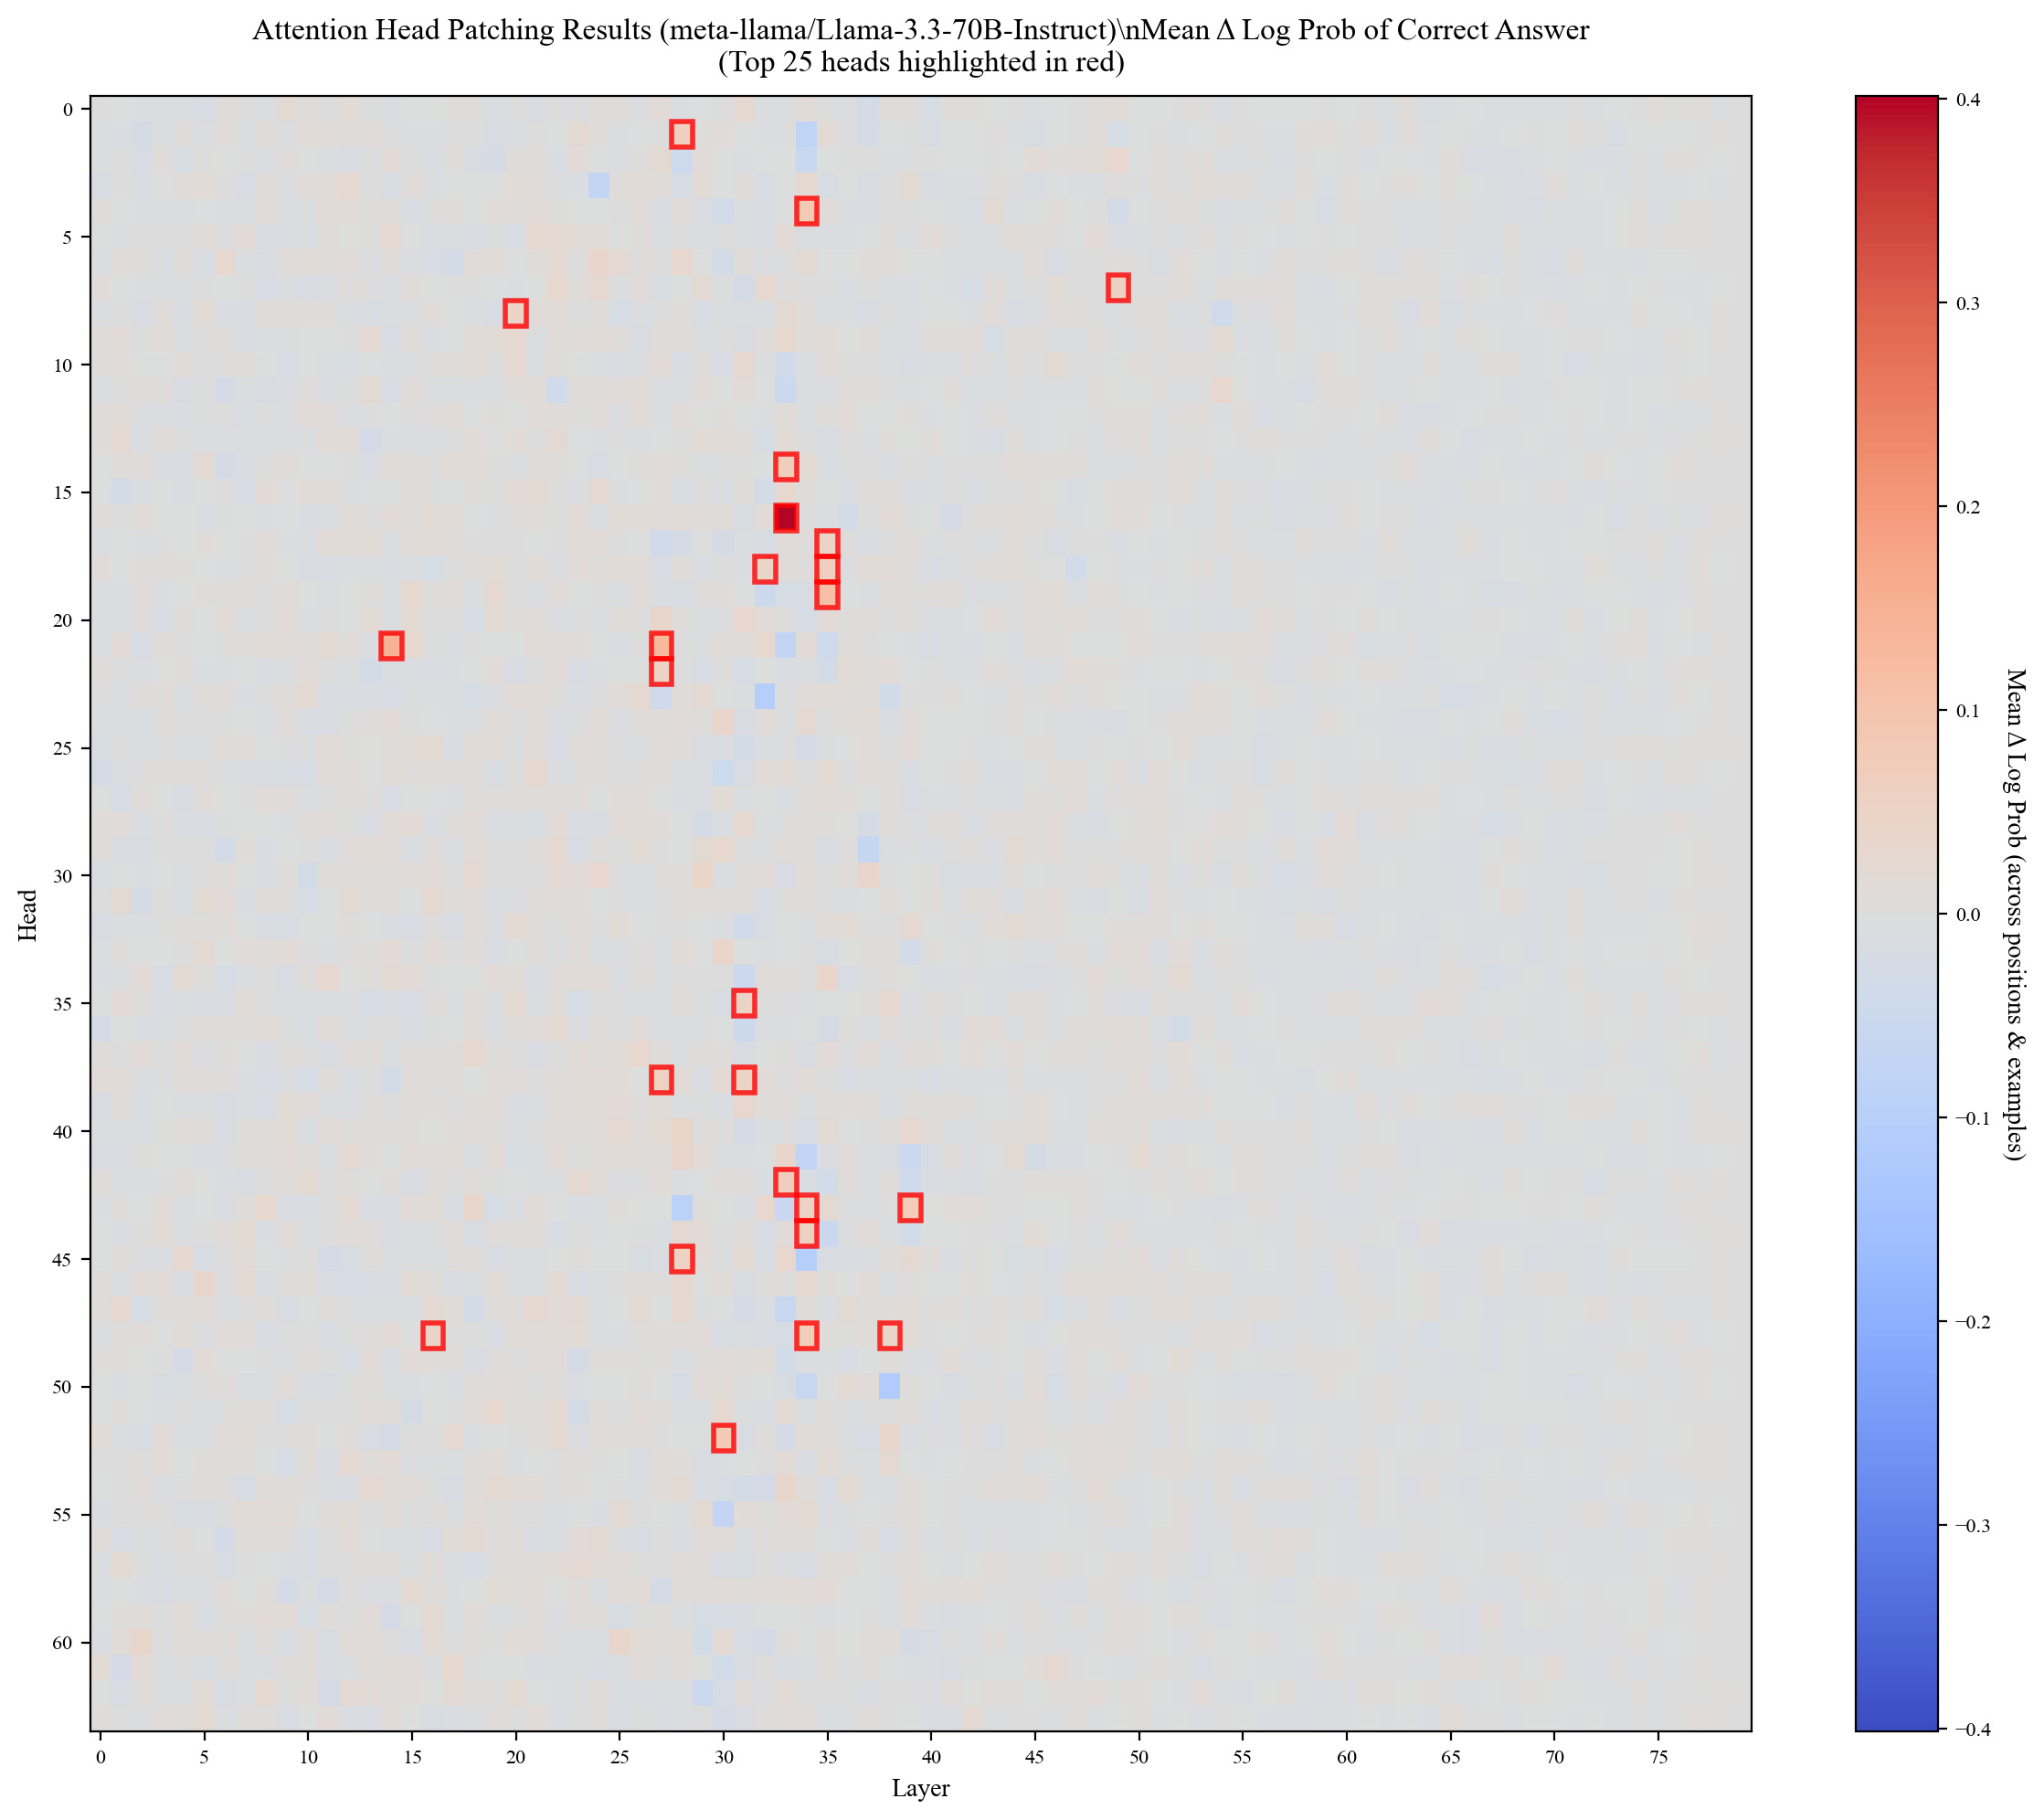

\nAttention heatmap saved to ../figures/attention_patch_heatmap_swapped.png
\nLayer/Head with highest mean absolute impact: L33H16


In [20]:
# --- Step 5: Analysis and Visualization ---

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

print("Aggregating attention patching results for heatmap...")

# Average the change in log probability across all examples and positions
mean_effects_attn = df_attn.groupby(['layer', 'head'])['log_prob_delta'].mean().reset_index()

# Create a pivot table with heads on the y-axis and layers on the x-axis
heatmap_data_attn = mean_effects_attn.pivot(index='head', columns='layer', values='log_prob_delta')

def attention_head_heatmap(
    results_df: pd.DataFrame,
    title: str = "Attention Head Patching Effects",
    top_k: int = None,
    highlight_color: str = 'red',
    highlight_linewidth: float = 2.0
) -> None:
    """
    Visualize the patching heatmap for attention heads.
    
    Args:
        results_df: DataFrame with heads as index, layers as columns, values as effects
        title: Title for the plot
        top_k: Number of top heads to highlight with squares (based on absolute effect)
        highlight_color: Color for the highlighting squares
        highlight_linewidth: Line width for the highlighting squares
    """
    # N_HEADS and N_LAYERS are inferred from the shape of the pivoted data
    N_HEADS, N_LAYERS = results_df.shape
    scores = results_df.to_numpy()
    
    print(f"Plotting data with shape (heads, layers): {scores.shape}")
    print(f"Data range: min={scores.min():.4f}, max={scores.max():.4f}")
    
    # Calculate top-k heads if specified
    top_k_positions = []
    if top_k is not None and top_k > 0:
        # Flatten the scores and get absolute values with their original positions
        abs_scores_flat = scores.flatten()
        head_indices, layer_indices = np.meshgrid(range(N_HEADS), range(N_LAYERS), indexing='ij')
        head_indices_flat = head_indices.flatten()
        layer_indices_flat = layer_indices.flatten()
        
        # Get indices of top-k absolute values
        top_k_indices = np.argpartition(abs_scores_flat, -top_k)[-top_k:]
        top_k_values = abs_scores_flat[top_k_indices]
        
        # Sort by value (highest first)
        sorted_indices = np.argsort(top_k_values)[::-1]
        top_k_indices = top_k_indices[sorted_indices]
        
        # Convert back to (head, layer) coordinates
        for idx in top_k_indices:
            head_pos = head_indices_flat[idx]
            layer_pos = layer_indices_flat[idx]
            effect_value = scores[head_pos, layer_pos]
            top_k_positions.append((head_pos, layer_pos, effect_value))
        
        print(f"\nTop {top_k} heads by absolute effect:")
        for i, (head, layer, value) in enumerate(top_k_positions):
            print(f"  {i+1:2d}. L{layer}H{head}: {value:+.4f}")

    plt.rcdefaults()
    with plt.rc_context(
        rc={
            "font.family": "Times New Roman",
            "font.size": 8,
        }
    ):
        # Adjusted figsize for better aspect ratio
        fig, ax = plt.subplots(figsize=(12, 10), dpi=200)
        
        vmax = np.abs(scores).max() if np.abs(scores).max() > 0 else 1.0
        scale_kwargs = {"vmin": -vmax, "vmax": vmax, "cmap": "coolwarm"}

        heatmap = ax.pcolor(scores, **scale_kwargs)
        ax.invert_yaxis()
        
        # Draw squares around top-k heads
        if top_k_positions:
            from matplotlib.patches import Rectangle
            for head_pos, layer_pos, _ in top_k_positions:
                # Rectangle coordinates: (x, y, width, height)
                # Note: pcolor coordinates are (layer, head) but we need (x=layer, y=head)
                rect = Rectangle(
                    (layer_pos, head_pos), 1, 1,
                    linewidth=highlight_linewidth,
                    edgecolor=highlight_color,
                    facecolor='none',
                    alpha=0.8
                )
                ax.add_patch(rect)
        
        # --- Updated Ticks and Labels ---
        # Y-axis for Heads
        y_tick_indices = np.arange(0, N_HEADS, 5)
        ax.set_yticks(y_tick_indices + 0.5)
        ax.set_yticklabels(y_tick_indices)
        
        # X-axis for Layers
        x_tick_indices = np.arange(0, N_LAYERS, 5)
        ax.set_xticks(x_tick_indices + 0.5)
        ax.set_xticklabels(x_tick_indices)

        # Update title to include top-k info if applicable
        full_title = title
        if top_k is not None and top_k > 0:
            full_title += f"\n(Top {top_k} heads highlighted in {highlight_color})"
        
        ax.set_title(full_title, fontsize=12, pad=10)
        ax.set_xlabel("Layer", fontsize=10)
        ax.set_ylabel("Head", fontsize=10)

        color_scale = plt.colorbar(heatmap)
        color_scale.ax.set_ylabel("Mean Δ Log Prob (across positions & examples)", rotation=-90, va="bottom", fontsize=10)

        plt.tight_layout()
        plt.show()

# --- Plotting the Results ---
plot_title_attn = f'Attention Head Patching Results ({MODEL_NAME})\\nMean Δ Log Prob of Correct Answer'

# Plot with top 50 heads highlighted
attention_head_heatmap(heatmap_data_attn, title=plot_title_attn, top_k=25)

# --- Save Figure and Display Top Head Info ---
# Create a new figure to save after showing the first one
fig = plt.gcf()
output_fig_path_attn = Path("../figures/attention_patch_heatmap_swapped.png")
output_fig_path_attn.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(output_fig_path_attn, dpi=300, bbox_inches='tight')
print(f"\\nAttention heatmap saved to {output_fig_path_attn}")

if not df_attn.empty:
    mean_abs_effect_by_head = df_attn.groupby(['layer', 'head'])['log_prob_delta'].mean().abs()
    best_head_idx = mean_abs_effect_by_head.idxmax()
    print(f"\\nLayer/Head with highest mean absolute impact: L{best_head_idx[0]}H{best_head_idx[1]}")


In [70]:
import pandas as pd
from pathlib import Path

# --- Step 5: Analyze and Find Top-K Heads ---

# Set how many of the top heads you want to see
K = 80

# Load the results from the CSV file
# If you have df_attn in memory, you can skip this and use it directly
results_path = Path("../data/attention_patching_results_o1_in_cue_16.csv")
if results_path.exists():
    df_attn = pd.read_csv(results_path)

    # Group by layer and head, then calculate the mean effect (log_prob_delta)
    head_effects = df_attn.groupby(['layer', 'head'])['log_prob_delta'].mean().reset_index()

    # Sort the heads by their effect in descending order to find the most impactful ones
    top_heads_df = head_effects.sort_values(by='log_prob_delta', ascending=False)

    # Display the top K heads and their average log_prob_delta
    print(f"Top {K} heads by mean log_prob_delta:")
    print(top_heads_df.head(K))

    # You can also get this as a list of tuples (layer, head)
    top_heads_list = list(zip(top_heads_df['layer'], top_heads_df['head']))
    print(f"\nTop {K} heads as a list of (layer, head) tuples:")
    print(top_heads_list[:K])
else:
    print(f"Results file not found at: {results_path}")
    print("Please make sure the experiment cell has finished and the CSV has been saved, or that `df_attn` is in memory.")


Top 80 heads by mean log_prob_delta:
      layer  head  log_prob_delta
2128     33    16        0.401367
917      14    21        0.147461
1749     27    21        0.131836
2259     35    19        0.113281
2180     34     4        0.083984
...     ...   ...             ...
1437     22    29        0.027344
111       1    47        0.027344
2222     34    46        0.026367
1543     24     7        0.026367
1514     23    42        0.026367

[80 rows x 3 columns]

Top 80 heads as a list of (layer, head) tuples:
[(33, 16), (14, 21), (27, 21), (35, 19), (34, 4), (30, 52), (39, 43), (34, 48), (33, 42), (33, 14), (35, 18), (28, 1), (34, 44), (27, 38), (49, 7), (28, 45), (35, 17), (34, 43), (27, 22), (31, 38), (31, 35), (16, 48), (20, 8), (38, 48), (32, 18), (28, 40), (29, 30), (35, 34), (30, 33), (30, 24), (24, 6), (33, 41), (2, 60), (5, 46), (27, 20), (18, 43), (33, 54), (25, 60), (37, 30), (28, 41), (38, 52), (26, 37), (32, 43), (39, 40), (49, 2), (33, 45), (31, 20), (28, 6), (24, 30), (